In [5]:
import sys
sys.path.append('/home/jovyan/workspace')

## Development

In [6]:
import numpy as np
import underworld as uw
from underworld import function as fn
import math
import time
import tarfile
import os
import shutil
import json
import itertools
import inspect
import importlib
import csv

# from . import utilities
# from .standards import standardise
# from .utilities import message
# from .utilities import unpack_var

from planetengine import utilities
from planetengine import standardise
from planetengine import message
from planetengine import initials
from planetengine import unpack_var
from planetengine import mapping
from planetengine.standards import ignoreVal
from planetengine import shapes

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nProcs = comm.Get_size()

In [7]:
def _return(outVar, opTag, opTags, updateFunc, updateFuncs):
    if opTags is None:
        opTags = ''
    opTags = opTag + '{' + opTags + '}'
    if updateFuncs is None:
        updateFuncs = []
    updateFuncs.append(updateFunc)
    return outVar, opTags, updateFuncs

def operations(operation, var, opTags = None, updateFuncs = None):

    opDict = {
        'abs': fn.math.abs,
        'cosh': fn.math.cosh,
        'acosh': fn.math.acosh,
        'tan': fn.math.tan,
        'asin': fn.math.asin,
        'log': fn.math.log,
        'atanh': fn.math.atanh,
        'sqrt': fn.math.sqrt,
        'abs': fn.math.abs,
        'log10': fn.math.log10,
        'sin': fn.math.sin,
        'asinh': fn.math.asinh,
        'log2': fn.math.log2,
        'atan': fn.math.atan,
        'sinh': fn.math.sinh,
        'cos': fn.math.cos,
        'tanh': fn.math.tanh,
        'erf': fn.math.erf,
        'erfc': fn.math.erfc,
        'exp': fn.math.exp,
        'acos': fn.math.acos,
        'dot': fn.math.dot
        }
    # ^^^ not all of these will work yet...
    if not operation in opDict:
        raise Exception

    opFn = opDict[operation]
    outVar = opFn(var)

    opTag = 'Operation_' + operation
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def component(component, var, opTags = None, updateFuncs = None):

    varDict = unpack_var(var, return_dict = True)
    if not varDict['varDim'] == varDict['mesh'].dim:
        # hence is not a vector and so has no components:
        raise Exception
    if component == 'mag':
        outVar = fn.math.sqrt(fn.math.dot(var, var))
    else:
        pemesh = standardise(varDict['mesh'])
        outVar = fn.math.dot(var, pemesh.comps[component])

    opTag = 'Component_' + component
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def gradient(gradient, var, opTags = None, updateFuncs = None):

    varDict = unpack_var(var, return_dict = True)
    pemesh = standardise(varDict['mesh'])
    projection = utilities.make_projector(var)
    project = projection.project
#     projVar, project = pemesh.meshify(
#         var,
#         return_project = True
#         )
    varGrad = projection.fn_gradient
    if gradient == 'mag':
        outVar = fn.math.sqrt(fn.math.dot(varGrad, varGrad))
    else:
        outVar = fn.math.dot(varGrad, pemesh.comps[gradient])
    project()

    opTag = 'Gradient_' + gradient
    updateFunc = project

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def bucket(bucket, var, opTags = None, updateFuncs = None):

    if type(bucket) is tuple:
        adjBucket = list(bucket)
        if bucket[0] == '.':
            adjBucket[0] = 1e-18
        if bucket[1] == '.':
            adjBucket[1] = 1e18
        bucketStr = str(bucket[0]) + ':' + str(bucket[1])
    else:
        adjBucket = (bucket - 1e-18, bucket + 1e-18)
        bucketStr = str(bucket)

    outVar = fn.branching.conditional([
        (var < adjBucket[0], np.nan),
        (var > adjBucket[1], np.nan), # double-open interval - is this a problem?
        (True, var),
        ])

    opTag = 'Bucket_' + bucketStr
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def quantile(ntiles, nthtile, var, opTags = None, updateFuncs = None):

    if not (type(ntiles) is int and type(nthtile) is int):
        raise Exception

    lowerBound = fn.misc.constant(0.)
    upperBound = fn.misc.constant(0.)

    def update_bounds():
        var_scales = utilities.get_scales(var)
        var_ranges = np.array(
            [maxVal - minVal for minVal, maxVal in var_scales]
            )
        intervalSize = var_ranges / ntiles
        lowerBound.value = var_scales[:,0] + intervalSize * (nthtile - 1)
        upperBound.value = var_scales[:,0] + intervalSize * (nthtile)

    update_bounds()

    l_adj = -1e-18
    if nthtile == ntiles:
        u_adj = -1e-18
    else:
        u_adj = 1e-18
    outVar = fn.branching.conditional([
        (var < lowerBound + l_adj, np.nan),
        (var > upperBound + u_adj, np.nan),
        (True, var),
        ])

    quantileStr = str(nthtile) + 'of' + str(ntiles)
    opTag = 'Quantile_' + quantileStr
    updateFunc = update_bounds

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def substitute(fromVal, toVal, var, opTags = None, updateFuncs = None):

    outVar = fn.branching.conditional([
        (fn.math.abs(var - fromVal) < 1e-18, toVal),
        (True, var),
        ])

    opTag = 'Substitute_' + str(fromVal) + ':' + str(toVal)
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def binarise(var, opTags = None, updateFuncs = None):

    outVar = 0. * var + fn.branching.conditional([
        (fn.math.abs(var) < 1e-18, 0.),
        (True, 1.),
        ])

    opTag = 'Binarise_'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def booleanise(var, opTags = None, updateFuncs = None):

    outVar = 0. * var + fn.branching.conditional([
        (fn.math.abs(var) < 1e-18, False),
        (True, True),
        ])

    opTag = 'Booleanise_'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def handleNaN(var, opTags = None, updateFuncs = None, handleVal = 0.):

    outVar = fn.branching.conditional([
        (var < np.inf, var),
        (True, handleVal),
        ])

    opTag = 'HandleNaN_' + str(handleVal)
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def region(region_name, inShape, var, opTags = None, updateFuncs = None):

    varDict = unpack_var(var, return_dict = True)
    inShape = shapes.interp_shape(inShape)
    inShape = mapping.unbox(varDict['mesh'], inShape)

    polygon = fn.shape.Polygon(inShape)
    outVar = fn.branching.conditional([
        (polygon, var),
        (True, np.nan),
        ])

    opTag = 'Region_' + region_name
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

## Testing

In [8]:
from modelscripts import arrhenius
from planetengine import quickShow
import planetengine

In [9]:
system = arrhenius.build(res = 64, Ra = 1e4, f = 0.5, aspect = 1., eta0 = 10.)
initials.apply(
    {'temperatureField': initials.sinusoidal.IC(freq = 1.)},
    system,
    )
system.solve()

In [ ]:
quickShow(system.temperatureField, system.velocityField)

In [ ]:
# key = 'velocityField'
# var, name = system.varsOfState[key], key
# shape = np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]])
# shape = shapes.layer(0., 0.3)
# shape = shapes.trapezoid()
# anFunc, opTag, updates = gradient('rad', var, name)
# anFunc, opTag, updates = region('test', shape, var, name)
# anFunc, opTag, updates = handleNaN(*region('test', shape, var, name))
# anFunc, opTag, updates = binarise(*handleNaN(*region('test', shape, var)))
# anFunc, opTag, updates = booleanise(*region('test', shape, var))
# anFunc, opTag, updates = handleNaN(*quantile(5, 2, *region('test', shape, var)))

In [ ]:
var, name = system.velocityField, 'velocityField'

In [ ]:
anFunc, opTag, updates = component(
    'mag',
    var,
    name
    )
print(opTag)
quickShow(anFunc)

In [ ]:
shape = np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]])
anFunc, opTag, updates = region(
    'test',
    shape,
    *component(
        'mag',
        var,
        name
        )
    )
print(opTag)
quickShow(anFunc)

In [ ]:
anFunc, opTag, updates = quantile(
    3,
    3,
    *region(
        'test',
        shape,
        *component(
            'mag',
            var,
            name
            )
        )
    )
print(opTag)
quickShow(anFunc)

In [ ]:
anFunc, opTag, updates = \
    binarise(
        *handleNaN(
            *quantile(
                3,
                3,
                *region(
                    'test',
                    shape,
                    *component(
                        'mag',
                        var,
                        name
                        )
                    )
                )
            )
        )
print(opTag)
quickShow(anFunc)

In [10]:
var, name = system.temperatureField, 'temperatureField'

Bucket_0.3:0.7{temperatureField}
Fitted 1 variables to the figure.



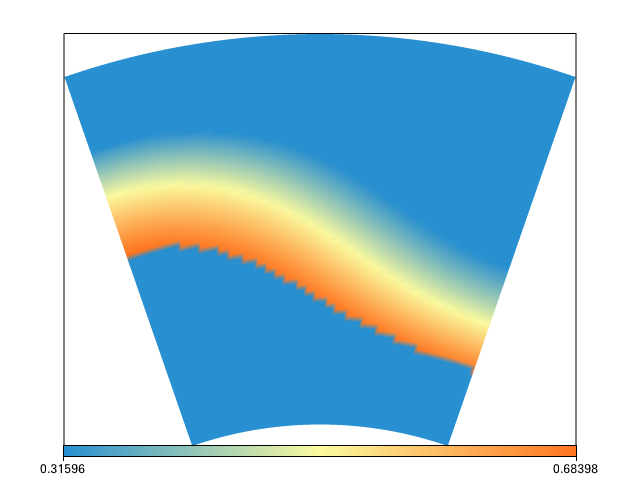

In [11]:
anFunc, opTag, updates = \
    bucket((0.3, 0.7), var, name)
print(opTag)
quickShow(anFunc)

Binarise_{HandleNaN_0.0{Bucket_0.6:.{Region_test{temperatureField}}}}
Fitted 1 variables to the figure.



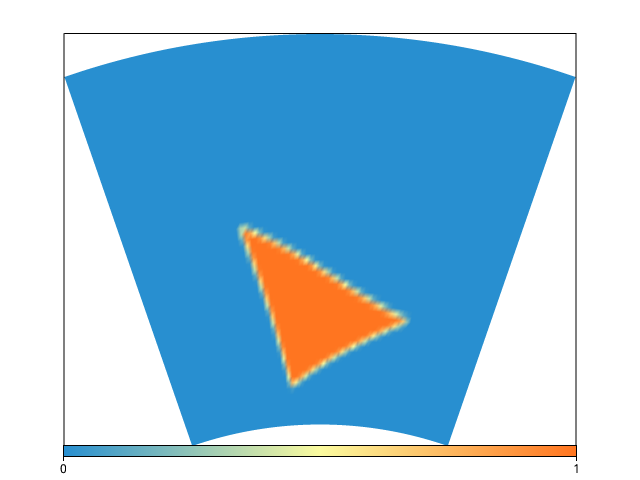

In [12]:
shape = np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]])
anFunc, opTag, updates = \
    binarise(
        *handleNaN(
            *bucket(
                (0.6, '.'),
                *region(
                    'test',
                    shape,
                    var,
                    name
                    )
                )
            )
        )
shapeFunc, shapeTag, shapeUpdates = \
    binarise(
        *handleNaN(
            *region(
                'test',
                shape,
                var,
                name
                )
            )
        )
for updateFunc in shapeUpdates:
    updateFunc()
print(opTag)
quickShow(anFunc, shapeFunc)

In [ ]:
utilities.get_valSets(shapeFunc.evaluate(system.mesh))

In [ ]:
np.round(shapeFunc.pevar.meshVar.data)

In [4]:
0. in {0}

True